# Lab CMBLenses

## Model

In [2]:
using CMBLensing, CMBLensingInferenceTestProblem
using CUDA, LaTeXStrings, MCMCDiagnosticTools, Plots, ProgressMeter, Random, Zygote
using LinearAlgebra, Statistics
ENV["LINES"] = 10;

┌ Error: JULIA_CUDA_USE_BINARYBUILDER is deprecated, and CUDA.jl always uses artifacts now.
│ To use a local installation, use overrides or preferences to customize the artifact.
│ Please check the CUDA.jl or Pkg.jl documentation for more details.
└ @ CUDA ~/.julia/packages/CUDA/is36v/src/initialization.jl:146
┌ Error: JULIA_CUDA_VERSION is deprecated. Call `CUDA.jl.set_runtime_version!` to use a different version instead.
└ @ CUDA ~/.julia/packages/CUDA/is36v/src/initialization.jl:153


In [3]:
using Revise
using MicroCanonicalHMC

In [ ]:
prob = load_cmb_lensing_problem(storage = Array,
                                T = Float32,
                                Nside = 64);

In [5]:
target = CMBLensingTarget(prob);

In [ ]:
d = length(prob.Ωstart[:])
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(prob.Ωstart);

## Sample

In [7]:
#spl=MCHMC(10.0, 10.0*sqrt(50); sigma=one(LenseBasis(diag(target.Λmass))))
spl = MCHMC(500, 0.0001;  adaptive=true, init_eps=10.0, init_L=10.0*sqrt(50), sigma=one(LenseBasis(diag(target.Λmass))))

MicroCanonicalHMC.Sampler(Settings(500, 0.0001, 1, true, "LF", 10.0, 70.71067811865476, nothing), Hyperparameters(0.0, 0.0, 0.0, 0.1931833275037836, Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 0.9607843137254902, 1.5), MicroCanonicalHMC.Leapfrog)

In [ ]:
samples = Sample(spl, target, 1000, dialog=false, progress=true)

In [87]:
samples_redux = []
for sample in samples
    if all(isfinite.(sample))
            append!(samples_redux, [sample])
    end
end

In [ ]:
_samples = zeros(length(samples), length(samples[1]), 1)
_samples[:, :, 1] = mapreduce(permutedims, vcat, samples)
_samples = permutedims(_samples, (1,3,2));

In [ ]:
ess, rhat = MCMCDiagnosticTools.ess_rhat(_samples[:,:,end÷2-1:end÷2])

In [93]:
_ess = minimum(ess)

5.719920260011557

In [94]:
_rhat = maximum(rhat)

1.2068531360764623

## Plotting

In [95]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

In [96]:
rs = [sample[1:d][end-1] for sample in samples_redux]
Aϕs = [sample[1:d][end] for sample in samples_redux];

In [97]:
p_rs = [sample[d:2d][end-1] for sample in samples_redux]
p_Aϕs = [sample[d:2d][end] for sample in samples_redux];

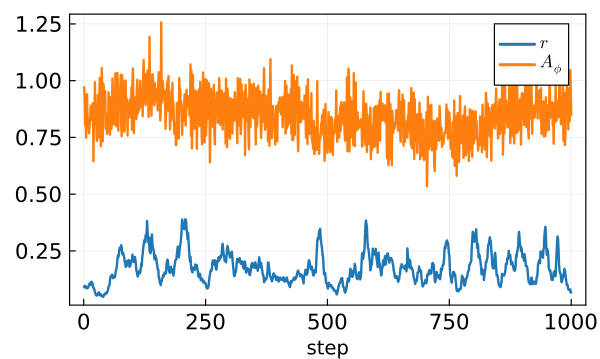

In [98]:
plot(exp.(rs), label=L"r", xlabel="step")
plot!(exp.(Aϕs), label=L"A_\phi")


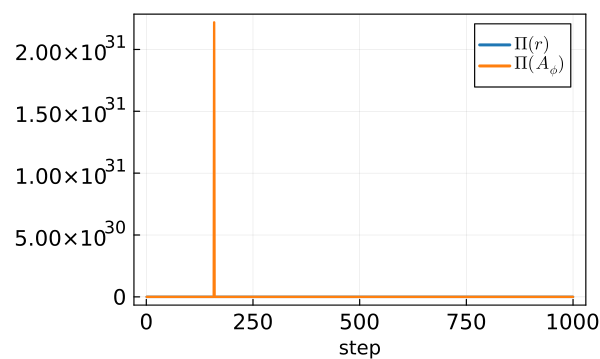

In [99]:
plot(exp.(p_rs), label=L"\Pi(r)", xlabel="step")
plot!(exp.(p_Aϕs), label=L"\Pi(A_\phi)")


In [100]:
Energy = [sample[end-1] for sample in samples_redux];
std(Energy)^2/d

0.00010239552164402965

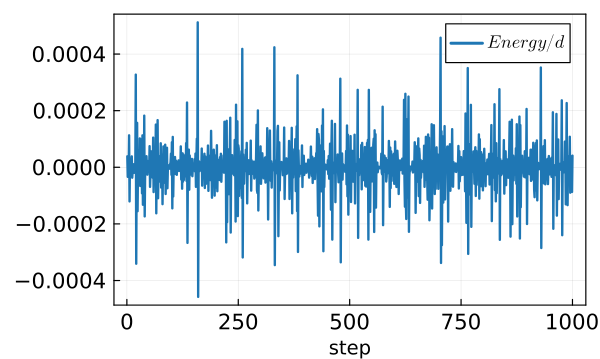

In [101]:
plot(Energy/d, label=L"Energy/d", xlabel="step")

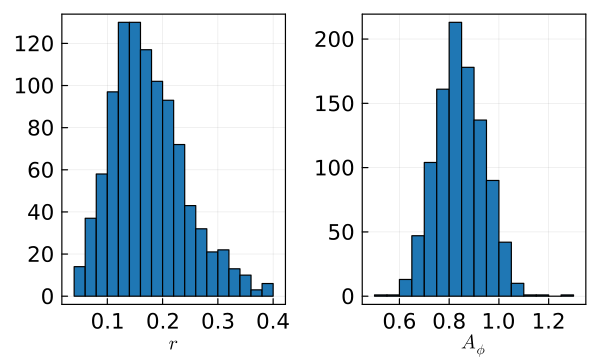

In [102]:
plot(histogram(exp.(rs), xlabel=L"r", label=nothing, lw=1),
    histogram(exp.(Aϕs), xlabel=L"A_\phi", label=nothing, lw=1))

In [103]:
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(prob.Ωstart)
last_sample = from_vec(samples[end][1:end-2]);

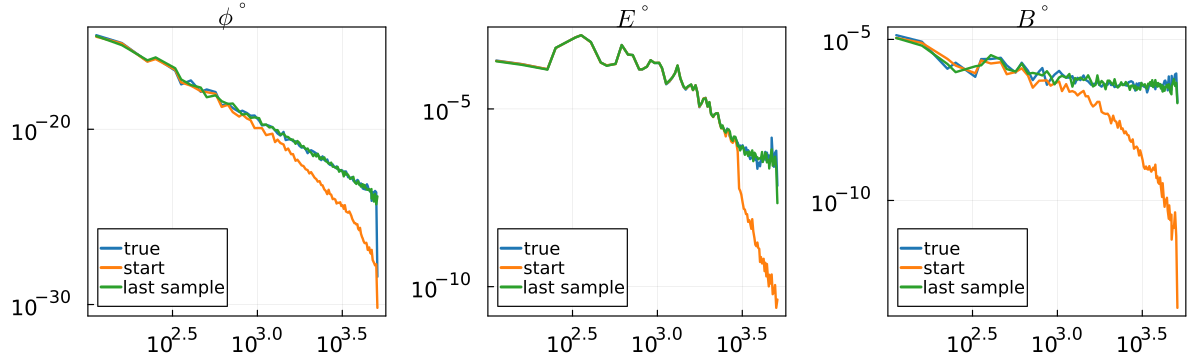

GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27


In [104]:
ps = map([(:ϕ°,:I,L"L",L"\phi^\circ"), (:f°,:E,"L\ell",L"E^\circ"), (:f°,:B,L"\ell",L"B^\circ")]) do (k1, k2, xlabel, title)
    plot(get_Cℓ(prob.Ωtrue[k1][k2]); label="true", xlabel, title)
    plot!(get_Cℓ(prob.Ωstart[k1][k2]); label="start", xlabel, title)
    plot!(get_Cℓ(last_sample[k1][k2]); label="last sample", xlabel, title)
end
plot(ps..., layout=(1,3), xscale=:log10, yscale=:log10, size=(1000,300), legend=:bottomleft)

In [ ]:
samps = [∇²*from_vec(sample[1:end-2]).ϕ°/2 for sample in samples[100:end]]
anim = @animate for i in 1:length(samps)
    motionblur = [0.5, 1, 0.5]
    frame = sum(circshift(samps, i)[1:length(motionblur)] .* motionblur) / sum(motionblur)
    plot(1 * frame, clims=(-0.5, 0.5), c=:thermal, title="κ samples")
end;

In [ ]:
mp4(anim, "kappa_samples.mp4", fps = 25)